# Network topology evaluation of adjacencies calculated from expression data
**Authorship:** Adam Klie (last updated: 08/09/2023)<br>
***
**Description:** This notebook takes in any adjacencies calculated on the Parse sequencing of the `igvf_b01_LeftCortex` dataset and uses CellOracle functions to evaluate the network topology of the adjacencies. 
***

# Set-up

In [116]:
import os
import sys
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [117]:
# CellOracle
import celloracle as co
co.__version__

'0.14.0'

In [118]:
from igraph import Graph

In [119]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [120]:
def read_aracne_out(filename):
    return pd.read_csv(filename, sep='\t')

def read_genie3_out(filename):
    return pd.read_csv(filename, sep='\t')

def read_scenic_out(filename):
    return pd.read_csv(filename, skiprows=3, header=None)

def aracne_out_to_co(
    df,
    copy=False,
):
    """Converts the output of ARACNE to a CellOracle compatible format."""
    if copy:
        df = df.copy()
    df.rename(columns={"Regulator": "source", "Target": "target", "MI": "weight", "pvalue": "p"}, inplace=True)
    df["coef_abs"] = df["weight"].abs()
    return df if copy else None

def genie3_out_to_co(
    df,
    copy=False,
):
    """Converts the output of GENIE3 to a CellOracle compatible format."""
    if copy:
        df = df.copy()
    df.rename(columns={"TF": "source", "importance": "weight"}, inplace=True)
    df["p"] = np.nan
    df["coef_abs"] = df["weight"].abs()
    return df if copy else None

def scenic_out_to_co(
    df
):
    """Co"""
    rows = []
    for i, row in df.iterrows():
        tf = row[0]
        target_string = row[8]
        target_list = target_string.rstrip("]").lstrip("[").split("),")
        for target in target_list:
            target = target.replace("(", "").replace("'", "")
            target_split = target.split(",")
            targ = target_split[0].strip()
            weight = float(target_split[1].strip().strip(")"))
            rows.append([tf, targ, weight])
    return_df = pd.DataFrame(rows, columns=["source", "target", "weight"])
    return_df["p"] = np.nan
    return_df["coef_abs"] = return_df["weight"].abs()
    return return_df

def wgcna_out_to_co(
    df,
    tf_list="/cellar/users/aklie/data/scenic/tf_lists/allTFs_mm.txt",
    copy=False
):
    """Converts the output of WGCNA to a CellOracle compatible format."""
    if copy:
        df = df.copy()
    tfs = pd.read_csv(tf_list, header=None)[0].values
    df = df[df["regulatoryGene"].isin(tfs)]
    df['minGene'] = df[['regulatoryGene', 'targetGene']].min(axis=1)
    df['maxGene'] = df[['regulatoryGene', 'targetGene']].max(axis=1)
    df = df.drop_duplicates(subset=['minGene', 'maxGene'])
    df = df.drop(columns=['minGene', 'maxGene'])
    df.rename(columns={"regulatoryGene": "source", "targetGene": "target"}, inplace=True)
    df["p"] = np.nan
    df["coef_abs"] = df["weight"].abs()
    return df if copy else None

In [121]:
input_dir = "/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference"
output_dir = "/cellar/users/aklie/projects/igvf/topic_grn_links/eval/network_topology/"
dataset = "igvf_b01_LeftCortex"

# Load files

In [122]:
# Get ARACNe files
aracne_adj_v1_files = sorted(glob.glob(os.path.join(input_dir, "aracne", "results", dataset, "2000", "**", "tfs", "network.txt")))
aracne_adj_files = sorted(glob.glob(os.path.join(input_dir, "aracne", "results", dataset, "0.05", "**", "tfs", "network.txt")))
aracne_adj_v1_files, aracne_adj_files

(['/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/aracne/results/igvf_b01_LeftCortex/2000/Microglia_B6J/tfs/network.txt',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/aracne/results/igvf_b01_LeftCortex/2000/Microglia_CASTJ/tfs/network.txt'],
 ['/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/aracne/results/igvf_b01_LeftCortex/0.05/B6J_filtered/tfs/network.txt',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/aracne/results/igvf_b01_LeftCortex/0.05/CASTJ_filtered/tfs/network.txt',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/aracne/results/igvf_b01_LeftCortex/0.05/filtered/tfs/network.txt'])

In [123]:
# Get GENIE3 files
genie3_adj_v1_files = sorted(glob.glob(os.path.join(input_dir, "genie3", "results", dataset, "*_adj.tsv")))
genie3_adj_files = sorted(glob.glob(os.path.join(input_dir, "genie3", "results", dataset, "0.05", "Microglia", "*_adj.tsv")))
genie3_adj_v1_files, genie3_adj_files

(['/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/genie3/results/igvf_b01_LeftCortex/Microglia_B6J_adj.tsv',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/genie3/results/igvf_b01_LeftCortex/Microglia_CASTJ_adj.tsv'],
 ['/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/genie3/results/igvf_b01_LeftCortex/0.05/Microglia/B6J_adj.tsv',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/genie3/results/igvf_b01_LeftCortex/0.05/Microglia/CASTJ_adj.tsv',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/genie3/results/igvf_b01_LeftCortex/0.05/Microglia/filtered_adj.tsv'])

In [124]:
# Get GRNBoost2 files
grnboost2_adj_v1_files = sorted(glob.glob(os.path.join(input_dir, "grnboost2", "results", dataset, "*_adj.tsv")))
grnboost2_adj_files = sorted(glob.glob(os.path.join(input_dir, "grnboost2", "results", dataset, "0.05", "Microglia", "*_adj.tsv")))
grnboost2_adj_v1_files, grnboost2_adj_files

(['/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/grnboost2/results/igvf_b01_LeftCortex/Microglia_B6J_adj.tsv',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/grnboost2/results/igvf_b01_LeftCortex/Microglia_CASTJ_adj.tsv'],
 ['/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/grnboost2/results/igvf_b01_LeftCortex/0.05/Microglia/B6J_adj.tsv',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/grnboost2/results/igvf_b01_LeftCortex/0.05/Microglia/CASTJ_adj.tsv',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/grnboost2/results/igvf_b01_LeftCortex/0.05/Microglia/filtered_adj.tsv'])

In [125]:
# Get SCENIC files
scenic_adj_v1_files = sorted(glob.glob(os.path.join(input_dir, "scenic", "results", dataset, "0.05", "*_reg.csv")))
scenic_adj_files = sorted(glob.glob(os.path.join(input_dir, "scenic", "results", dataset, "0.05", "Microglia", "filtered", "*_reg.csv")))
scenic_adj_v1_files, scenic_adj_files

(['/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/scenic/results/igvf_b01_LeftCortex/0.05/Microglia_B6J_reg.csv',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/scenic/results/igvf_b01_LeftCortex/0.05/Microglia_CASTJ_reg.csv'],
 ['/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/scenic/results/igvf_b01_LeftCortex/0.05/Microglia/filtered/B6J_filtered_reg.csv',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/scenic/results/igvf_b01_LeftCortex/0.05/Microglia/filtered/CASTJ_filtered_reg.csv',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/scenic/results/igvf_b01_LeftCortex/0.05/Microglia/filtered/filtered_reg.csv'])

In [126]:
# Get WGCNA files
wgcna_adj_files = sorted(glob.glob(os.path.join(input_dir, "hdwgcna", "results", dataset, "Microglia", "**", "adj.tsv"), recursive=True))
wgcna_adj_files

['/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/hdwgcna/results/igvf_b01_LeftCortex/Microglia/B6J_filtered/network_construction/adj.tsv',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/hdwgcna/results/igvf_b01_LeftCortex/Microglia/CASTJ_filtered/network_construction/adj.tsv',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/hdwgcna/results/igvf_b01_LeftCortex/Microglia/filtered/network_construction/adj.tsv']

In [251]:
# Get CellOracle files
celloracle_adj_v1_files = sorted(glob.glob(os.path.join(input_dir, "celloracle", "results", dataset, "*_adj.tsv")))
celloracle_adj_files = sorted(glob.glob(os.path.join(input_dir, "celloracle", "results", dataset, "filtered", "*_adj.tsv")))
celloracle_adj_v1_files, celloracle_adj_files

(['/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/celloracle/results/igvf_b01_LeftCortex/B6J_adj.tsv',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/celloracle/results/igvf_b01_LeftCortex/CASTJ_adj.tsv',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/celloracle/results/igvf_b01_LeftCortex/both_adj.tsv'],
 ['/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/celloracle/results/igvf_b01_LeftCortex/filtered/B6J_adj.tsv',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/celloracle/results/igvf_b01_LeftCortex/filtered/CASTJ_adj.tsv',
  '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/celloracle/results/igvf_b01_LeftCortex/filtered/filtered_adj.tsv'])

In [254]:
all_adj_v1_files = aracne_adj_v1_files + genie3_adj_v1_files + grnboost2_adj_v1_files + scenic_adj_v1_files + celloracle_adj_v1_files
all_adj_v1_files

['/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/aracne/results/igvf_b01_LeftCortex/2000/Microglia_B6J/tfs/network.txt',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/aracne/results/igvf_b01_LeftCortex/2000/Microglia_CASTJ/tfs/network.txt',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/genie3/results/igvf_b01_LeftCortex/Microglia_B6J_adj.tsv',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/genie3/results/igvf_b01_LeftCortex/Microglia_CASTJ_adj.tsv',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/grnboost2/results/igvf_b01_LeftCortex/Microglia_B6J_adj.tsv',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/grnboost2/results/igvf_b01_LeftCortex/Microglia_CASTJ_adj.tsv',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/scenic/results/igvf_b01_LeftCortex/0.05/Microglia_B6J_reg.csv',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/scenic/results/i

In [255]:
all_adj_files = aracne_adj_files + genie3_adj_files + grnboost2_adj_files + scenic_adj_files + wgcna_adj_files + celloracle_adj_files
all_adj_files

['/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/aracne/results/igvf_b01_LeftCortex/0.05/B6J_filtered/tfs/network.txt',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/aracne/results/igvf_b01_LeftCortex/0.05/CASTJ_filtered/tfs/network.txt',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/aracne/results/igvf_b01_LeftCortex/0.05/filtered/tfs/network.txt',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/genie3/results/igvf_b01_LeftCortex/0.05/Microglia/B6J_adj.tsv',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/genie3/results/igvf_b01_LeftCortex/0.05/Microglia/CASTJ_adj.tsv',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/genie3/results/igvf_b01_LeftCortex/0.05/Microglia/filtered_adj.tsv',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/grnboost2/results/igvf_b01_LeftCortex/0.05/Microglia/B6J_adj.tsv',
 '/cellar/users/aklie/projects/igvf/topic_grn_links/grn_infer

In [256]:
links_dict = {}
for file in all_adj_v1_files:
    method = file.split('/')[8]
    if method == "aracne":
        df = read_aracne_out(file)
        aracne_out_to_co(df)
        celltype = file.split('/')[-3].replace("Microglia_", "")
    elif method in ["genie3", "grnboost2"]:
        df = read_genie3_out(file)
        genie3_out_to_co(df)
        celltype = file.split('/')[-1].split(".")[0].replace("_adj", "").replace("Microglia_", "")
    elif method == "scenic":
        df = read_scenic_out(file)
        df = scenic_out_to_co(df)
        celltype = file.split('/')[-1].split(".")[0].replace("_reg", "").replace("Microglia_", "")
    elif method == "hdwgcna":
        df = pd.read_csv(file, sep="\t")
        df = wgcna_out_to_co(df, copy=True)
        celltype = file.split('/')[-3].replace("_filtered", "")
    elif method == "celloracle":
        df = pd.read_csv(file, sep="\t")
        df["weight"] = df["coef_abs"]
        celltype = file.split('/')[-1].split(".")[0].replace("_adj", "")
    df = df.drop_duplicates(subset=["source", "target"])
    df["coef_abs"] = (df["coef_abs"] - df["coef_abs"].min()) / (df["coef_abs"].max() - df["coef_abs"].min()) + 1e-8
    print(method, celltype + "_v1")
    links_dict[method + "_" + celltype + "_v1"] = df

aracne B6J_v1
aracne CASTJ_v1
genie3 B6J_v1
genie3 CASTJ_v1
grnboost2 B6J_v1
grnboost2 CASTJ_v1
scenic B6J_v1
scenic CASTJ_v1
celloracle B6J_v1
celloracle CASTJ_v1
celloracle both_v1


In [257]:
for file in all_adj_files:
    method = file.split('/')[8]
    if method == "aracne":
        df = read_aracne_out(file)
        aracne_out_to_co(df)
        celltype = file.split('/')[-3].replace("_filtered", "")
    elif method in ["genie3", "grnboost2"]:
        df = read_genie3_out(file)
        genie3_out_to_co(df)
        celltype = file.split('/')[-1].split(".")[0].replace("_adj", "")
    elif method == "scenic":
        df = read_scenic_out(file)
        df = scenic_out_to_co(df)
        celltype = file.split('/')[-1].split(".")[0].replace("_reg", "").replace("_filtered", "")
    elif method == "hdwgcna":
        df = pd.read_csv(file, sep="\t")
        df = wgcna_out_to_co(df, copy=True)
        celltype = file.split('/')[-3].replace("_filtered", "")
    elif method == "celloracle":
        df = pd.read_csv(file, sep="\t")
        df["weight"] = df["coef_abs"]
        celltype = file.split('/')[-1].split(".")[0].replace("_adj", "")
    df = df.drop_duplicates(subset=["source", "target"])

    # Min-max normalize the coef_abs value
    df["coef_abs"] = (df["coef_abs"] - df["coef_abs"].min()) / (df["coef_abs"].max() - df["coef_abs"].min()) + 1e-8
    print(method, celltype)
    
    # Min-max normalize
    links_dict[method + "_" + celltype] = df

aracne B6J
aracne CASTJ
aracne filtered
genie3 B6J
genie3 CASTJ
genie3 filtered
grnboost2 B6J
grnboost2 CASTJ
grnboost2 filtered
scenic B6J
scenic CASTJ
scenic filtered
hdwgcna B6J
hdwgcna CASTJ
hdwgcna filtered
celloracle B6J
celloracle CASTJ
celloracle filtered


In [258]:
# Replace string "_filtered" with "both" for all keys in link_dict
links_dict = {k.replace("_filtered", "_both"): v for k, v in links_dict.items()}
links_dict.keys()

dict_keys(['aracne_B6J_v1', 'aracne_CASTJ_v1', 'genie3_B6J_v1', 'genie3_CASTJ_v1', 'grnboost2_B6J_v1', 'grnboost2_CASTJ_v1', 'scenic_B6J_v1', 'scenic_CASTJ_v1', 'celloracle_B6J_v1', 'celloracle_CASTJ_v1', 'celloracle_both_v1', 'aracne_B6J', 'aracne_CASTJ', 'aracne_both', 'genie3_B6J', 'genie3_CASTJ', 'genie3_both', 'grnboost2_B6J', 'grnboost2_CASTJ', 'grnboost2_both', 'scenic_B6J', 'scenic_CASTJ', 'scenic_both', 'hdwgcna_B6J', 'hdwgcna_CASTJ', 'hdwgcna_both', 'celloracle_B6J', 'celloracle_CASTJ', 'celloracle_both'])

In [259]:
test = links_dict["aracne_CASTJ_v1"].sort_values("weight", ascending=False).head(2000)
test

,source,target,weight,p,coef_abs
48,Pbx1,Srrm2,0.266526,6.286646e-08,1.000000e+00
27,Zeb2,Celf2,0.243893,1.011566e-09,9.019062e-01
89,Kmt2a,Cst3,0.230978,1.678501e-04,8.459279e-01
116,Zeb2,Son,0.222300,6.962108e-03,8.083192e-01
56,Mlxipl,Sfi1,0.214902,1.461331e-11,7.762513e-01
...,...,...,...,...,...
92,Mlxipl,Fat3,0.047581,3.471661e-06,5.105832e-02
38,Rora,Celf2,0.047167,3.471661e-06,4.926440e-02
71,Gas7,Srgap2,0.045404,6.962108e-03,4.162064e-02
95,Kmt2a,Malat1,0.041534,6.962108e-03,2.485003e-02


In [217]:
g = Graph.DataFrame(test[["source", "target"]], directed=True, use_vids=False)
g.es["weight"] = test["coef_abs"].values.copy()
df = g.get_vertex_dataframe()
# Calculate scores
for i in ["all", "in", "out"]:
    df[f"degree_{i}"] = g.degree(mode=i)
    df[f"degree_centrality_{i}"] = df[f"degree_{i}"] / (df.shape[0]-1)
df["betweenness_centrality"] = g.betweenness(directed=True, weights="weight")
df["eigenvector_centrality"] = g.eigenvector_centrality(directed=False, weights="weight")

In [218]:
df.sort_values("degree_all", ascending=False).head(10)

,name,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality
vertex ID,,,,,,,,,
7,Mlxipl,45,0.584416,1,0.012987,44,0.571429,84.0,1.000000
4,Kmt2a,32,0.415584,1,0.012987,31,0.402597,82.0,0.515222
0,Pbx1,23,0.298701,2,0.025974,21,0.272727,60.0,0.761577
2,Zeb2,21,0.272727,2,0.025974,19,0.246753,58.0,0.578436
1,Srrm2,5,0.064935,5,0.064935,0,0.000000,0.0,0.539570
5,Cst3,4,0.051948,4,0.051948,0,0.000000,0.0,0.444597
16,Cdk8,3,0.038961,3,0.038961,0,0.000000,0.0,0.195838
25,Ly86,3,0.038961,3,0.038961,0,0.000000,0.0,0.245838
30,Dgki,3,0.038961,3,0.038961,0,0.000000,0.0,0.172402


In [260]:
# 
links = co.Links(name="Microglia_comparison", links_dict=links_dict)

In [261]:
#
links.filter_links(weight="weight", p=None, threshold_number=2000)

In [221]:
#links.plot_degree_distributions(plot_model=True, save=os.path.join(output_dir, dataset, "network_topology"))

In [262]:
links.filtered_links["celloracle_CASTJ_v1"]

,source,target,coef_mean,coef_abs,p,-logp,weight
148846,Mef2a,Nav3,0.262726,1.000000,4.715201e-16,15.326500,0.262726
56215,Mef2c,Csmd3,0.240635,0.915915,1.326706e-10,9.877225,0.240635
148800,Mef2a,Nav2,0.238210,0.906685,1.011925e-13,12.994852,0.238210
225774,Pbx1,Slc8a1,0.237371,0.903492,7.441528e-13,12.128338,0.237371
225777,Thrb,Slc8a1,-0.230625,0.877815,1.514296e-12,11.819789,0.230625
...,...,...,...,...,...,...,...
148819,Mafg,Nav2,-0.026269,0.099986,6.520451e-11,10.185722,0.026269
286695,Smad4,Zfhx3,0.026269,0.099985,3.290265e-09,8.482769,0.026269
14921,Glis3,Anks1b,-0.026266,0.099975,6.031156e-06,5.219599,0.026266
179495,Klf3,Ppcdc,0.026263,0.099962,5.563575e-12,11.254646,0.026263


In [263]:
# Calculate network scores.
links.get_network_score()

In [264]:
# 
gene_scores = links.merged_score
gene_scores.to_csv(os.path.join(output_dir, dataset, "gene_scores_v2.tsv"), sep="\t")

In [265]:
# assign a color to each key in links_dict based on a seaborn palette
palette = sns.color_palette('Paired', len(links_dict))
links.palette = pd.DataFrame({'key': links_dict.keys(), 'palette': palette}).set_index('key')

(0.0, 0.04)

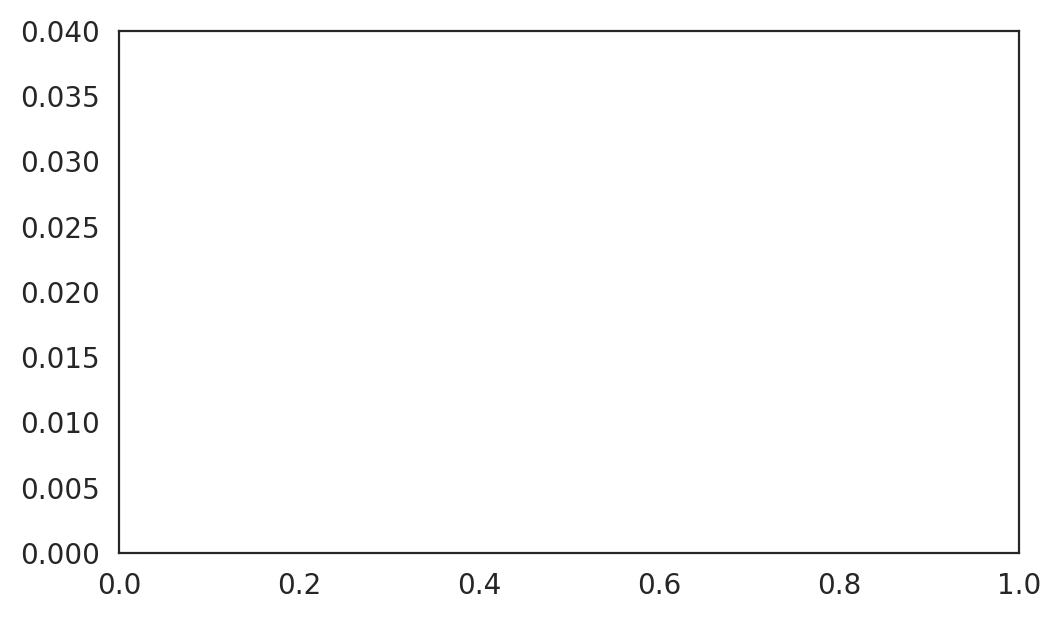

In [266]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.040])
#links.plot_score_discributions(values=links.merged_score.columns[:-1],
#                               method="boxplot")

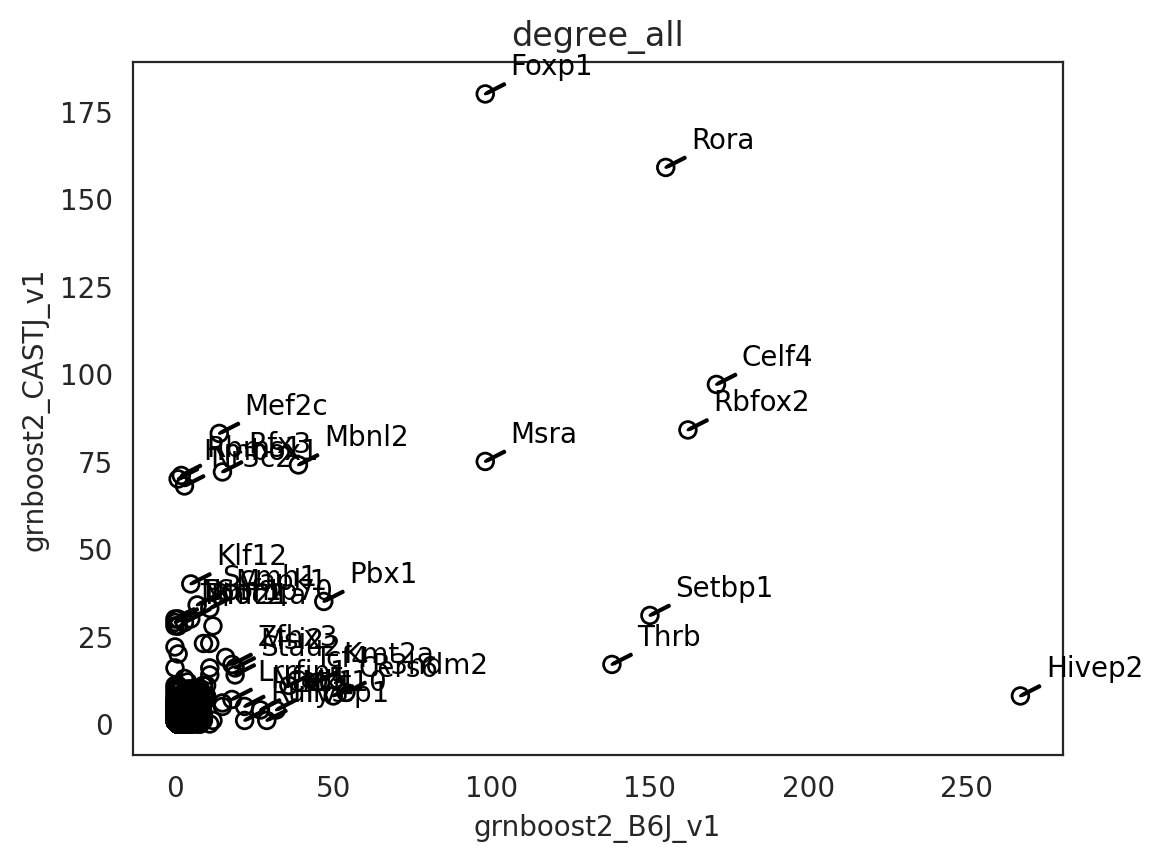

In [297]:
links.plot_score_comparison_2D(
    value="degree_all",
    cluster1="grnboost2_B6J_v1", 
    cluster2="grnboost2_CASTJ_v1",
    percentile=98
)

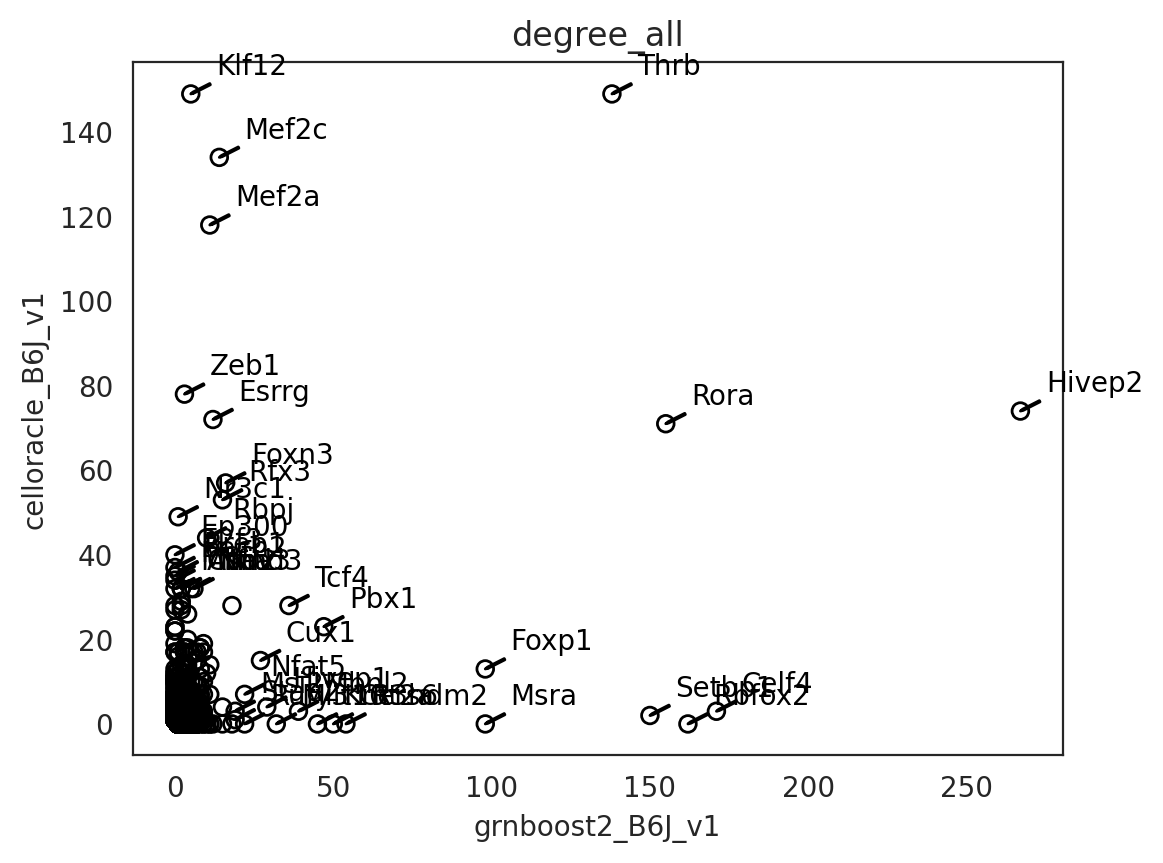

In [298]:
links.plot_score_comparison_2D(
    value="degree_all",
    cluster1="grnboost2_B6J_v1", 
    cluster2="celloracle_B6J_v1",
    percentile=98
)

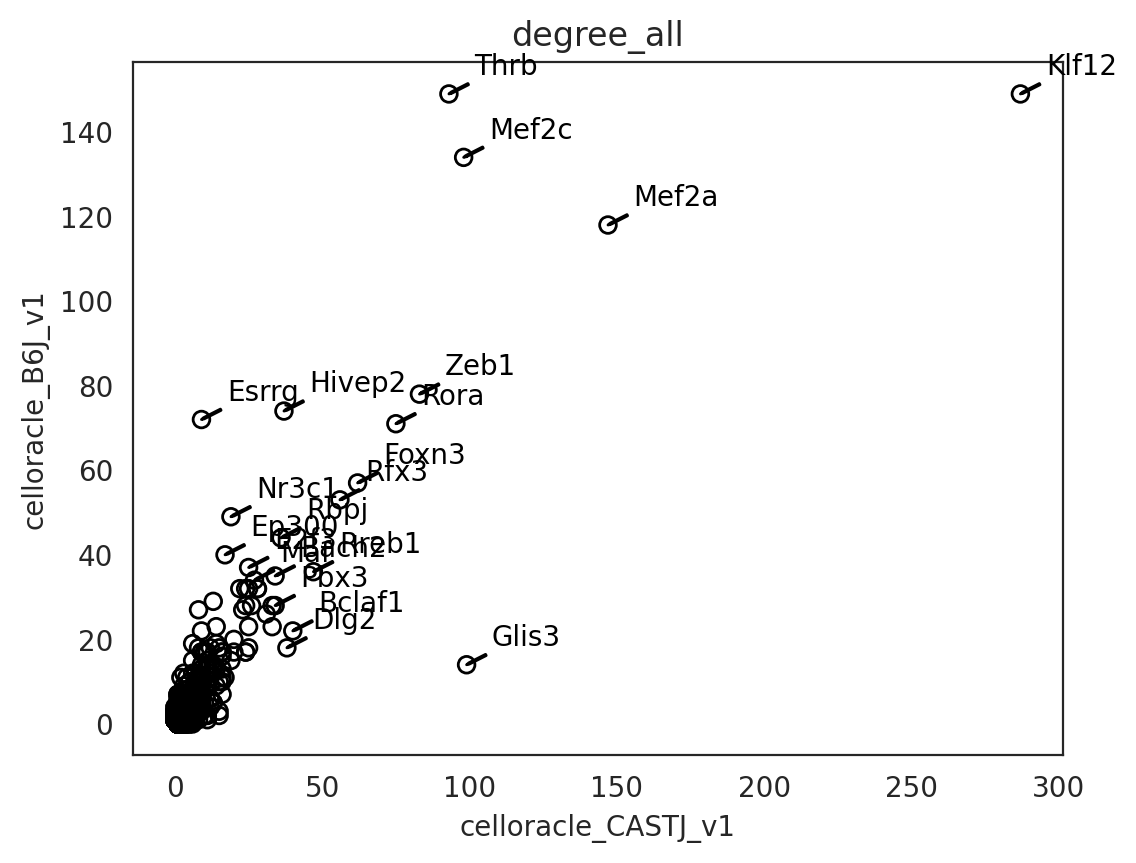

In [299]:
links.plot_score_comparison_2D(
    value="degree_all",
    cluster1="celloracle_CASTJ_v1", 
    cluster2="celloracle_B6J_v1",
    percentile=98
)

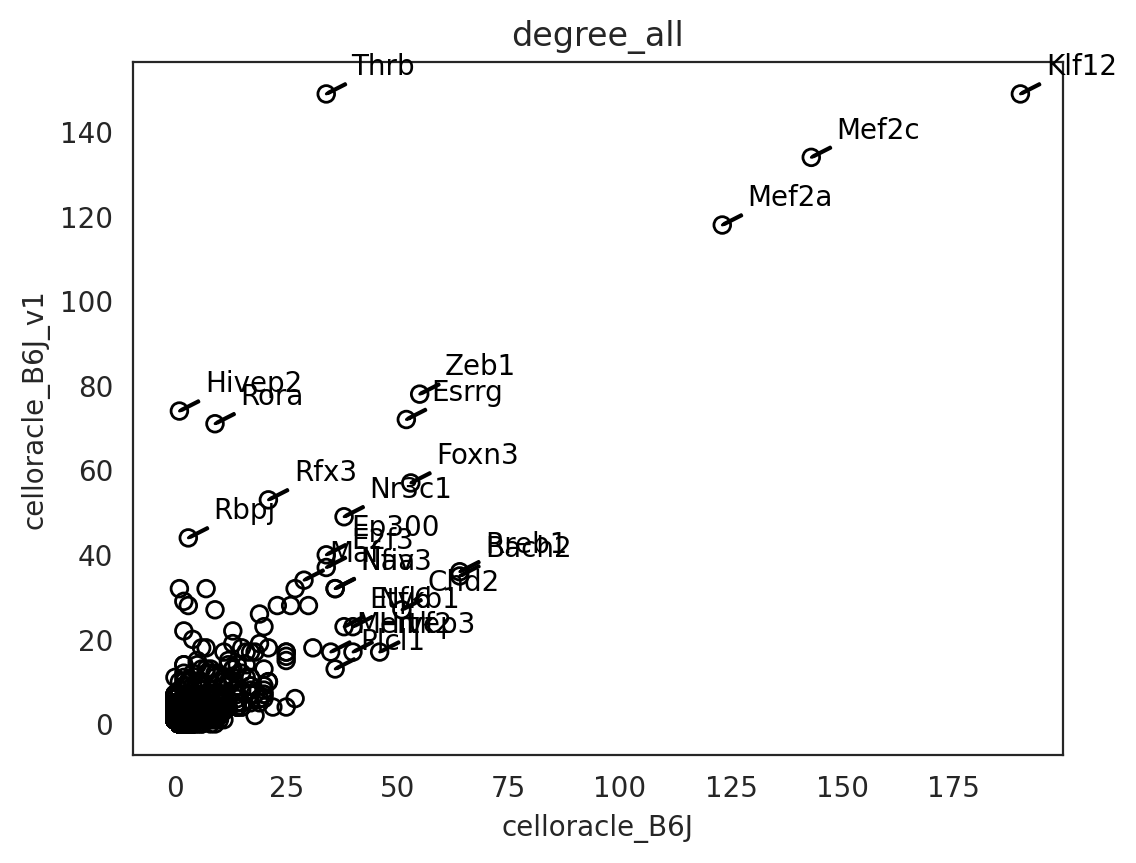

In [300]:
links.plot_score_comparison_2D(
    value="degree_all",
    cluster1="celloracle_B6J", 
    cluster2="celloracle_B6J_v1",
    percentile=98
)

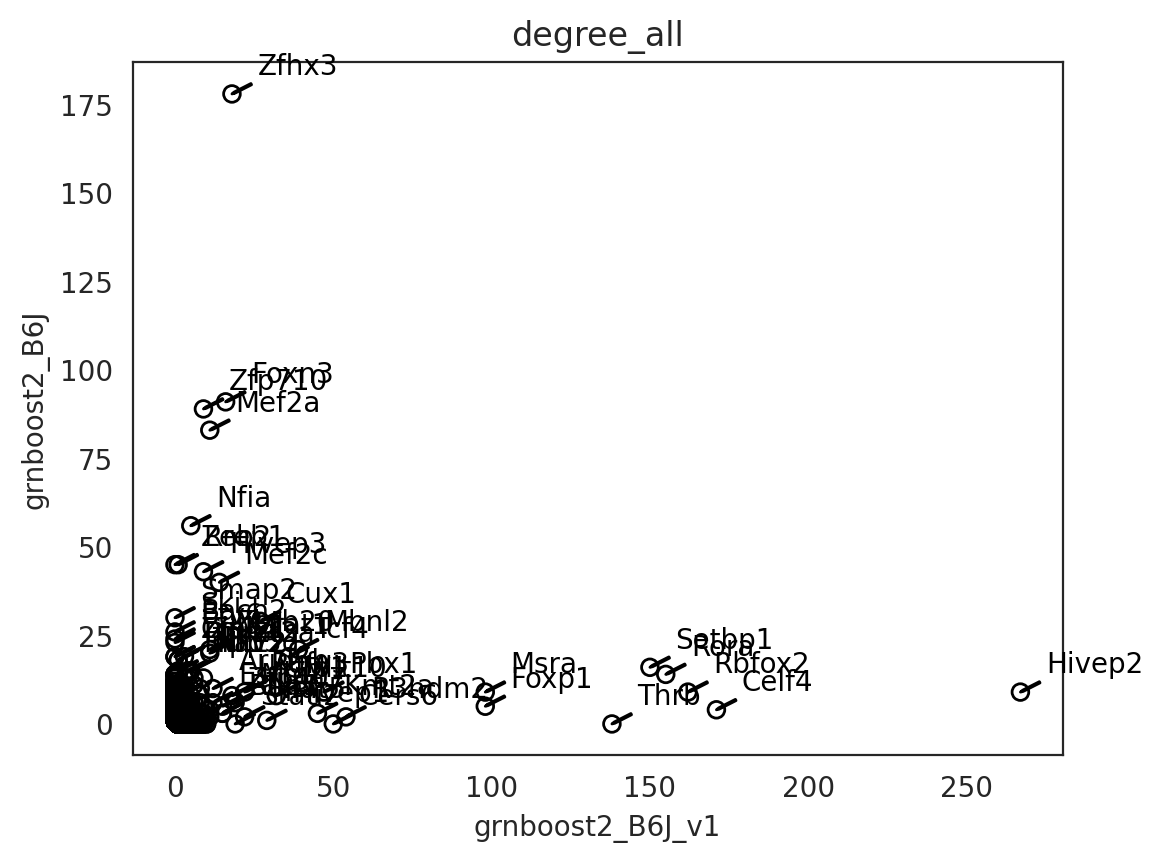

In [301]:
links.plot_score_comparison_2D(
    value="degree_all",
    cluster1="grnboost2_B6J_v1", 
    cluster2="grnboost2_B6J",
    percentile=98
)

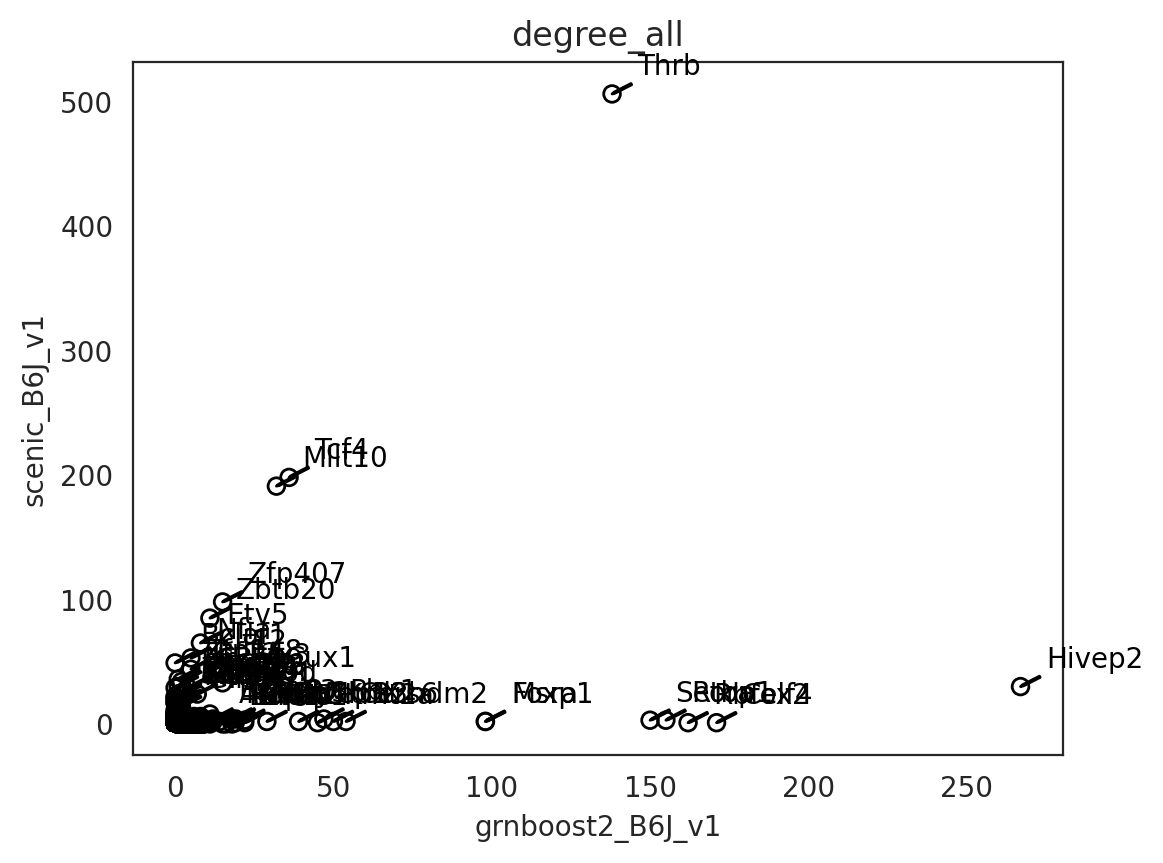

In [305]:
links.plot_score_comparison_2D(
    value="degree_all",
    cluster1="grnboost2_B6J_v1", 
    cluster2="scenic_B6J_v1",
    percentile=98
)

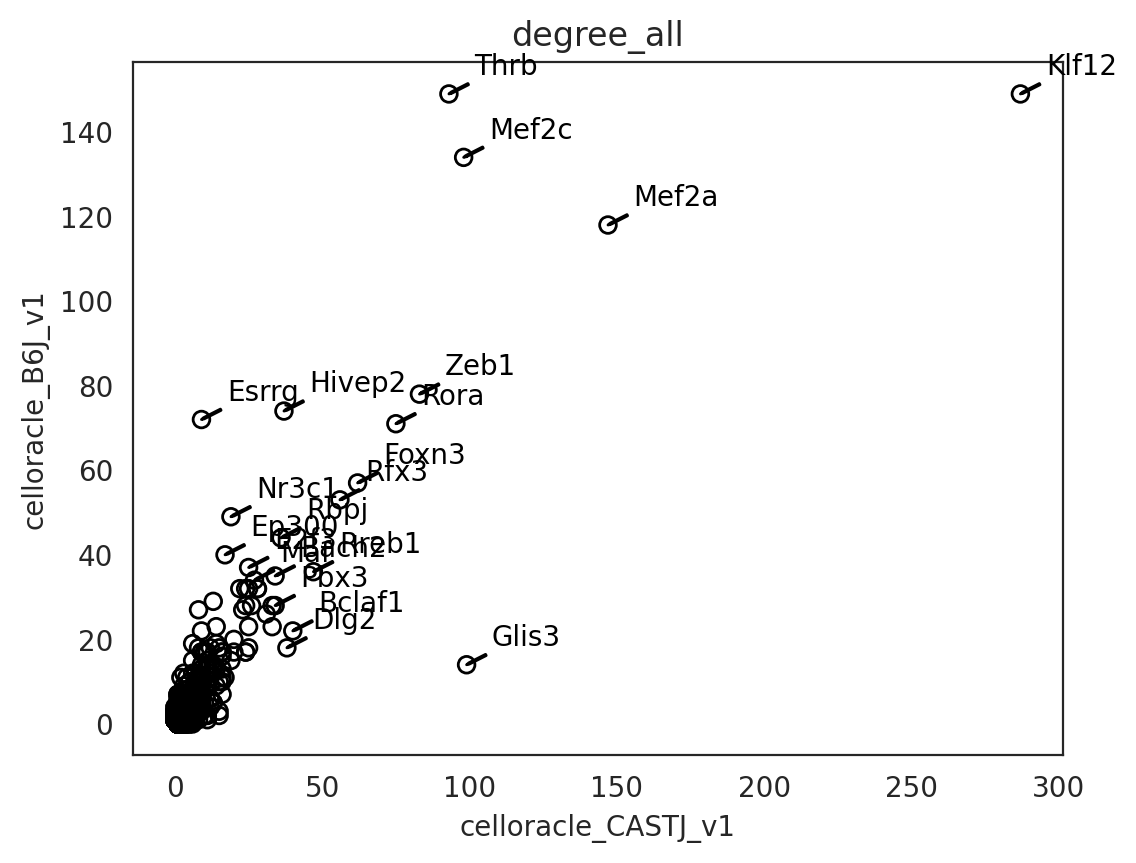

In [295]:
links.plot_score_comparison_2D(
    value="degree_all",
    cluster1="celloracle_CASTJ_v1", 
    cluster2="celloracle_B6J_v1",
    percentile=98
)

Hivep2


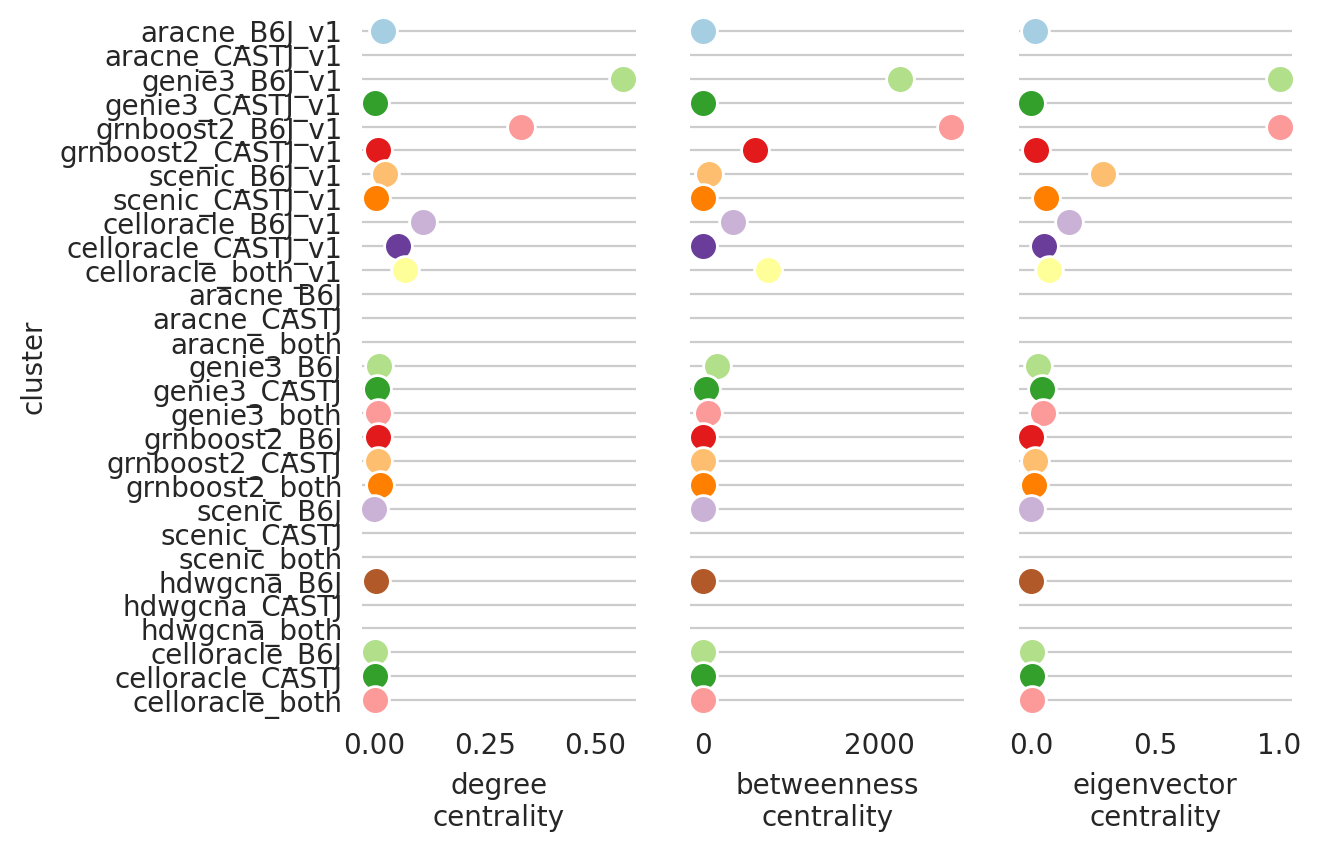

In [291]:
links.plot_score_per_cluster(goi="Hivep2")

In [284]:
plot_df = gene_scores.sort_values("degree_all", ascending=False).groupby("cluster").head(20)
plot_df = plot_df.pivot(columns='cluster', values="degree_all").fillna(0)

In [287]:
# Create column annotations for clustermap
cols = plot_df.columns
method = cols.split("_")[0]
data = cols.split("_")[1]

Index(['aracne_B6J', 'aracne_B6J_v1', 'aracne_CASTJ', 'aracne_CASTJ_v1',
       'aracne_both', 'celloracle_B6J', 'celloracle_B6J_v1',
       'celloracle_CASTJ', 'celloracle_CASTJ_v1', 'celloracle_both',
       'celloracle_both_v1', 'genie3_B6J', 'genie3_B6J_v1', 'genie3_CASTJ',
       'genie3_CASTJ_v1', 'genie3_both', 'grnboost2_B6J', 'grnboost2_B6J_v1',
       'grnboost2_CASTJ', 'grnboost2_CASTJ_v1', 'grnboost2_both',
       'hdwgcna_B6J', 'hdwgcna_CASTJ', 'hdwgcna_both', 'scenic_B6J',
       'scenic_B6J_v1', 'scenic_CASTJ', 'scenic_CASTJ_v1', 'scenic_both'],
      dtype='object', name='cluster')

In [ ]:
plot_df.to_csv('/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/celloracle/bin/igvf_b01_LeftCortex/plot_df.csv', index=False)

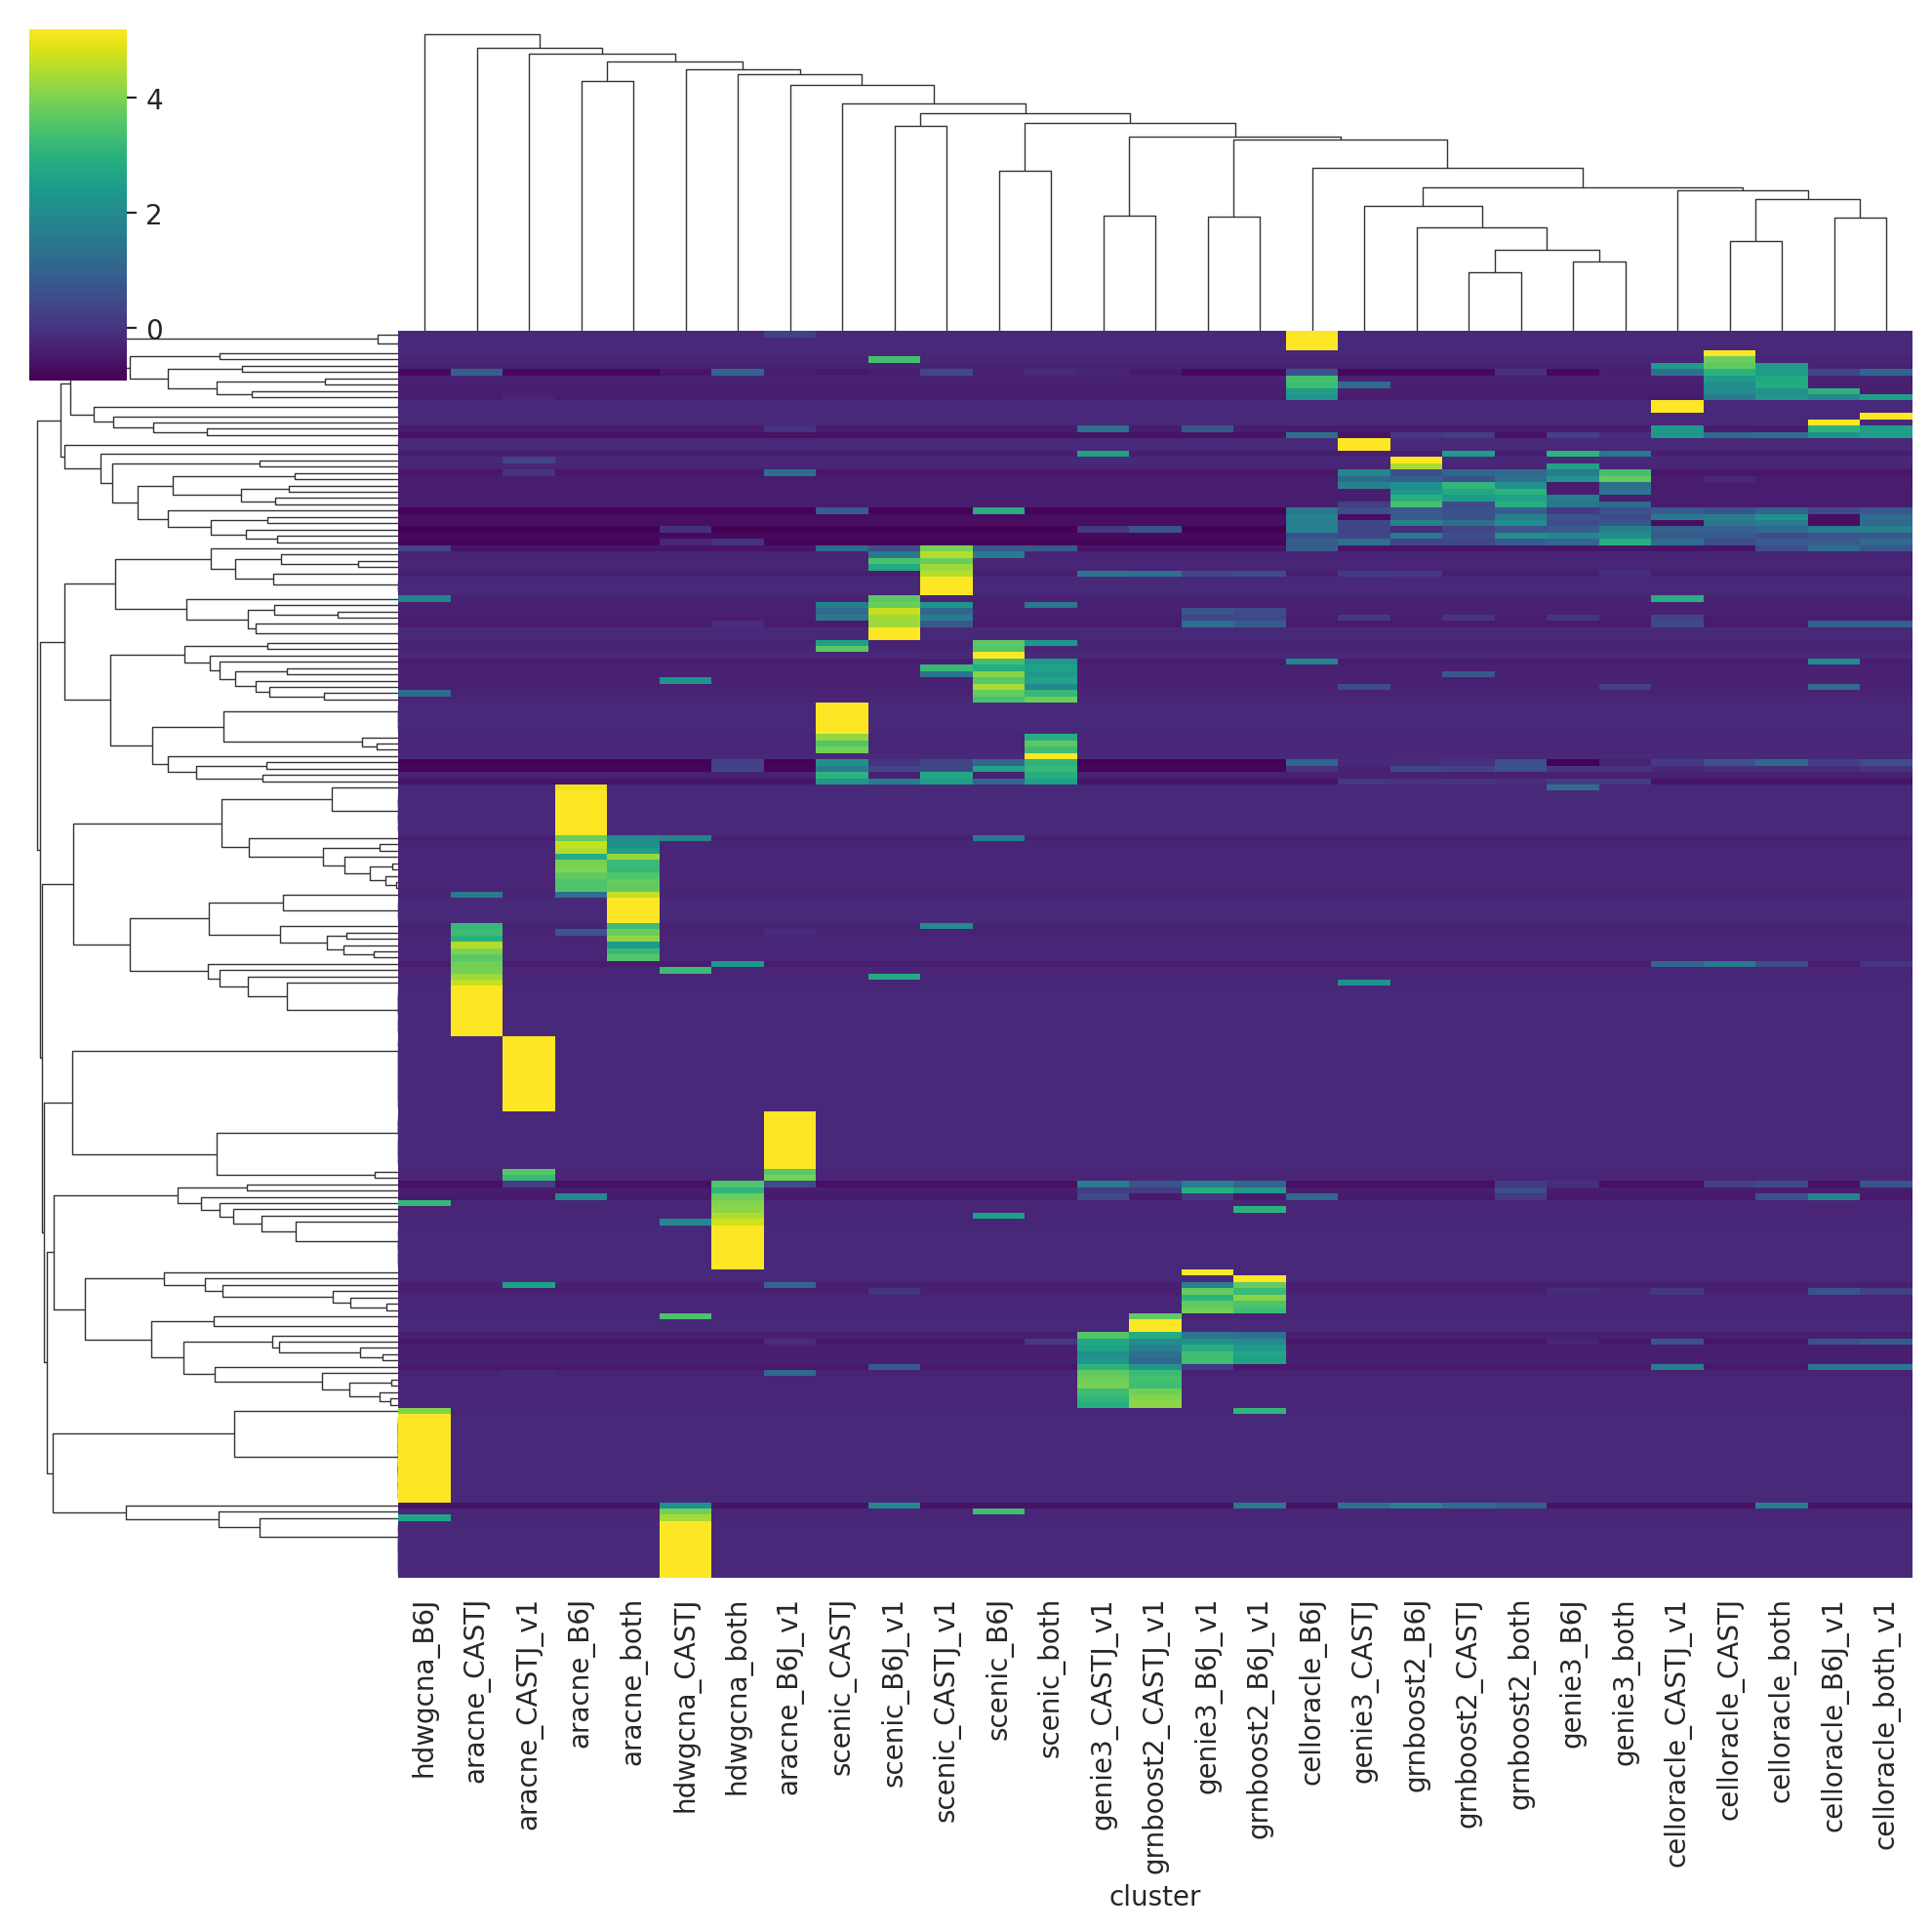

In [285]:
sns.clustermap(plot_df, cmap="viridis", figsize=(10, 10), row_cluster=True, col_cluster=True, z_score=0, yticklabels=False)

In [263]:
unique_genes = set()
for name, df in links.filtered_links.items():
    unique_genes.update(df['source'].unique())
    unique_genes.update(df['target'].unique())

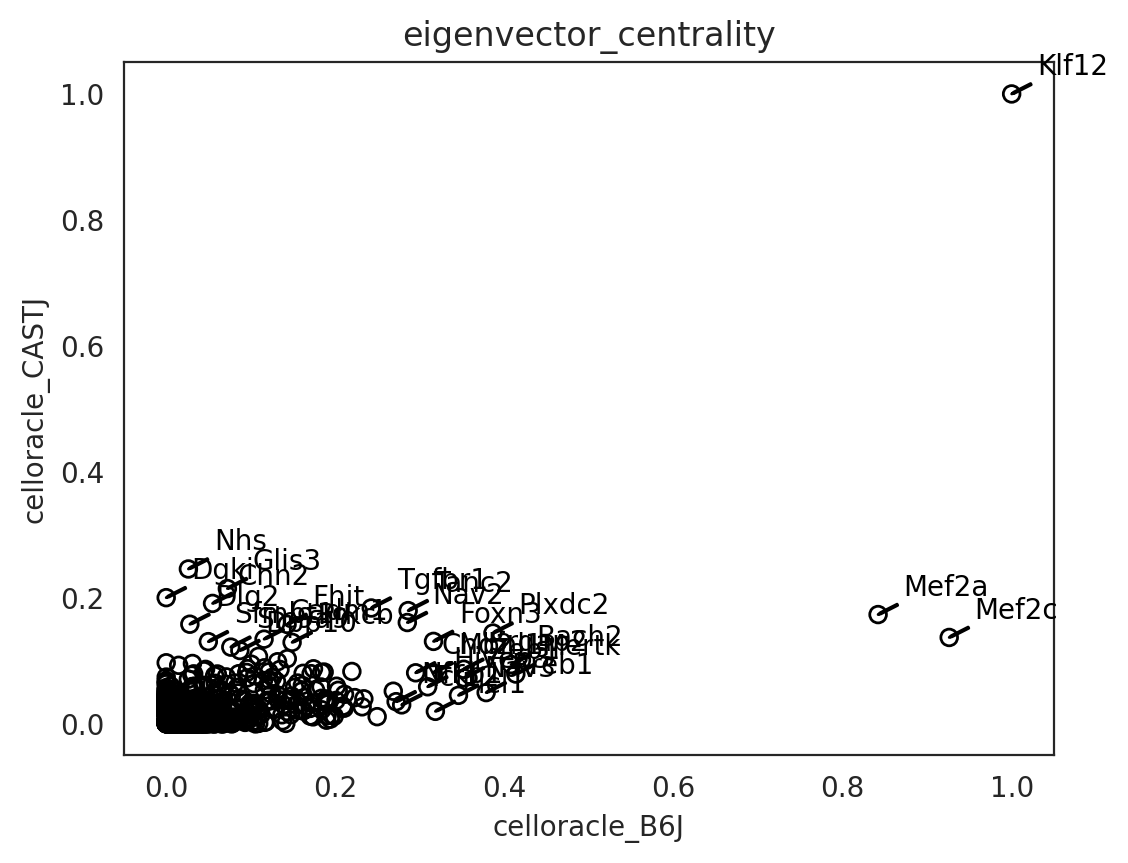

In [140]:
unique_genes = gene_scores.index.unique()

In [141]:
unique_genes

Index(['Hsf1', 'Cpd', 'Erf', 'Pygb', 'Gas7', 'Gnb4', 'Abi3bp', 'Srebf2',
       'Calm1', 'Crebzf',
       ...
       'Ube2q2', 'Gria1', 'Prpf38b', 'Ttc17', 'Adcy9', '2610037D02Rik',
       'Kpna3', 'Arfgef1', 'Zfc3h1', 'Eea1'],
      dtype='object', length=3220)

In [280]:
links.filtered_links.keys()

dict_keys(['aracne_Microglia_CASTJ', 'aracne_Microglia_B6J', 'genie3_Microglia_CASTJ_adj', 'genie3_Microglia_B6J_adj', 'grnboost2_Microglia_B6J_adj', 'grnboost2_Microglia_CASTJ_adj', 'scenic_Microglia_B6J_reg', 'scenic_Microglia_CASTJ_reg'])

In [283]:
b6j_links = links.filtered_links["grnboost2_Microglia_B6J_adj"]
castj_links = links.filtered_links["grnboost2_Microglia_CASTJ_adj"]

In [284]:
def links_to_adj(links_df, adj_genes):
    """Turn a CellOracle Links dataframe into an adjacency list
    
    Parameters
    ----------
    links_df : pandas.DataFrame
        A CellOracle Links dataframe. Must have columns "source" and "target".
    
    Returns
    -------
    pd.DataFrame
        Adjacency list representation of the links dataframe. Each row represents a unique "source" node, 
        each column a unique "target" node. The value of each cell should be 1 if there is a row in the input 
        links_df with the corresponding source and target nodes, and 0 otherwise.
    """
    adj = pd.DataFrame(0, index=adj_genes, columns=adj_genes)
    for i in range(len(links_df)):
        adj.loc[links_df.iloc[i]["source"], links_df.iloc[i]["target"]] = links_df["weight"][i]
    return adj

In [285]:
b6j_adj_list = links_to_adj(b6j_links, unique_genes)
castj_adj_list = links_to_adj(castj_links, unique_genes)

<AxesSubplot: ylabel='Frequency'>

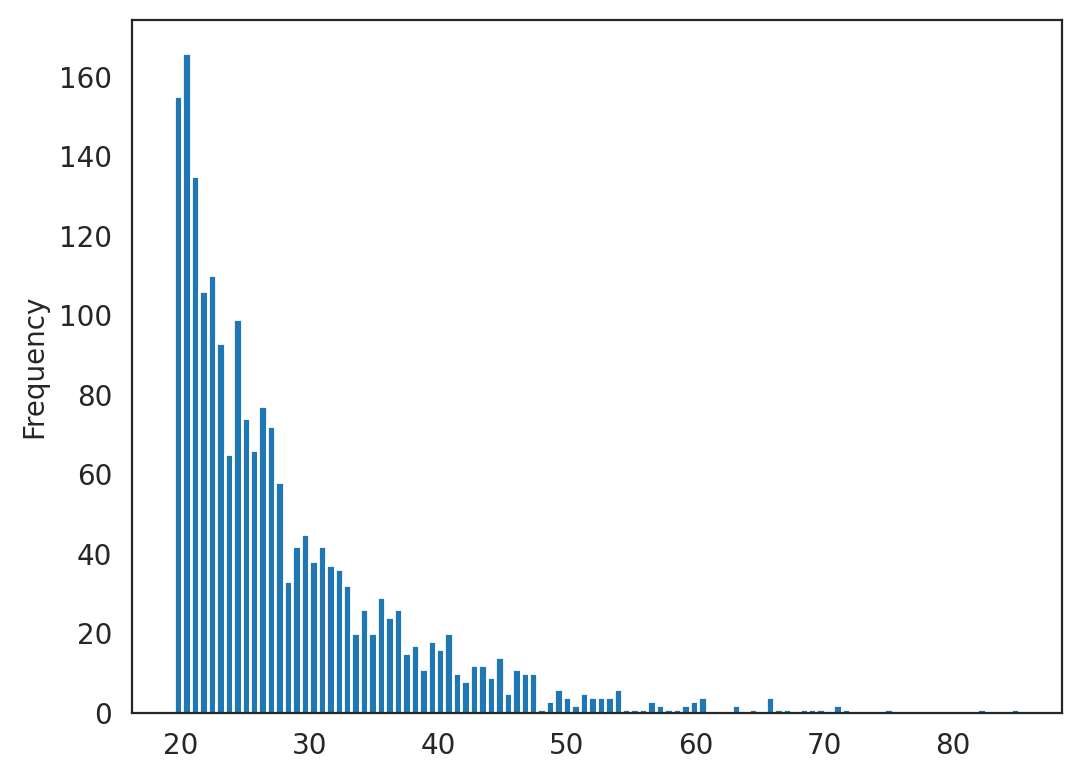

In [289]:
links.filtered_links["grnboost2_Microglia_B6J_adj"]["weight"].plot.hist(bins=100)

<AxesSubplot: ylabel='Frequency'>

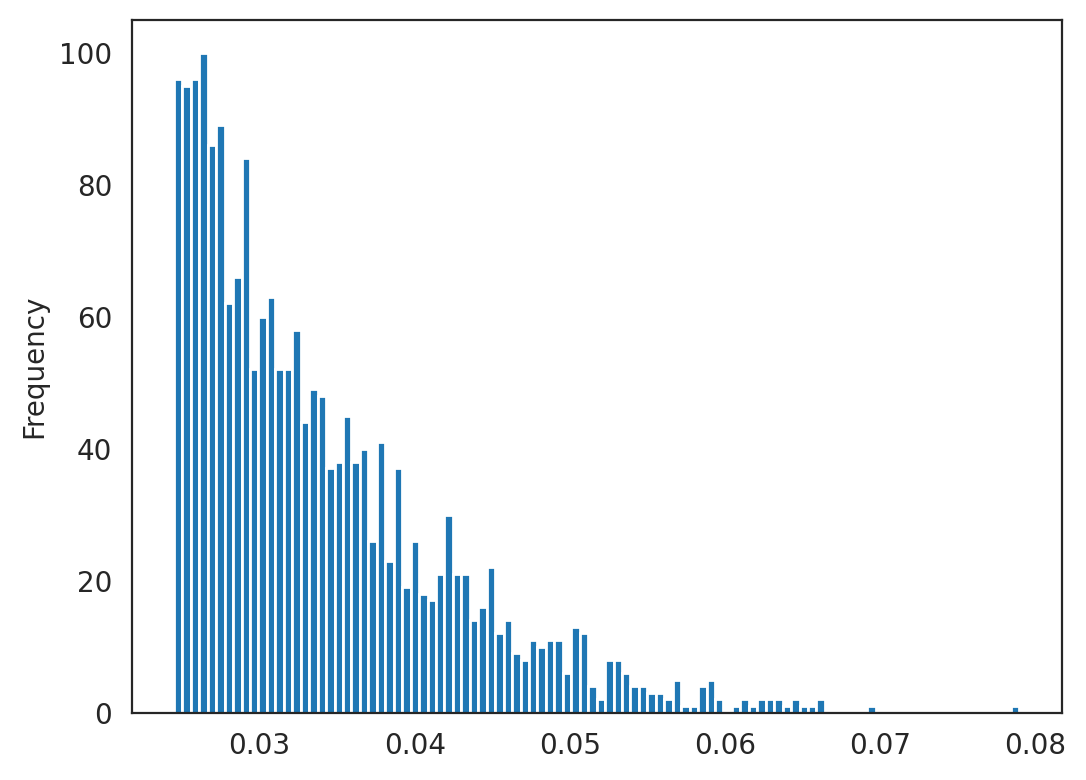

In [290]:
links.filtered_links["genie3_Microglia_B6J_adj"]["weight"].plot.hist(bins=100)

In [287]:
b6j_adj_list

,Pbx1,Srrm2,Zeb2,Celf2,Kmt2a,Cst3,Son,Mlxipl,Sfi1,Setbp1,...,Znrf1,Fxr1,Mgat5,Birc6,Dyrk1a,Trappc9,Kdm3a,Ccdc66,Cblb,Cdyl2
Pbx1,0.0,0.000000,0,0.0,0,0,0.0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
Srrm2,0.0,0.000000,0,0.0,0,0,0.0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
Zeb2,0.0,0.000000,0,0.0,0,0,0.0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
Celf2,0.0,0.000000,0,0.0,0,0,0.0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
Kmt2a,0.0,65.598416,0,0.0,0,0,0.0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trappc9,0.0,0.000000,0,0.0,0,0,0.0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
Kdm3a,0.0,0.000000,0,0.0,0,0,0.0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
Ccdc66,0.0,0.000000,0,0.0,0,0,0.0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
Cblb,0.0,0.000000,0,0.0,0,0,0.0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [291]:
diff_adj = b6j_adj_list - castj_adj_list

In [292]:
def adj_mtx_to_list(adj_mtx):
    """Converts adjacency matrix to list of edges.

    Parameters
    ----------
    adj_mtx : pd.DataFrame
        Adjacency matrix of the graph. Index and columns are the nodes.
    
    Returns
    -------
    pd.DataFrame
        List of edges with columns 'source', 'target', and 'weight'.
    """
    adj_mtx = adj_mtx.copy()
    adj_mtx = adj_mtx.stack().reset_index()
    adj_mtx.columns = ['source', 'target', 'weight']
    adj_mtx = adj_mtx[adj_mtx['weight'] != 0]
    return adj_mtx

In [296]:
diff_list = adj_mtx_to_list(diff_adj)

In [302]:
diff_list["coef_abs"] = diff_list["weight"].abs()

In [303]:
diff_links = co.Links(name="test_diff", links_dict={"genotype_diff": diff_list})

In [304]:
diff_links.filter_links(p=None, threshold_number=10000)

In [305]:
diff_links.get_network_score()

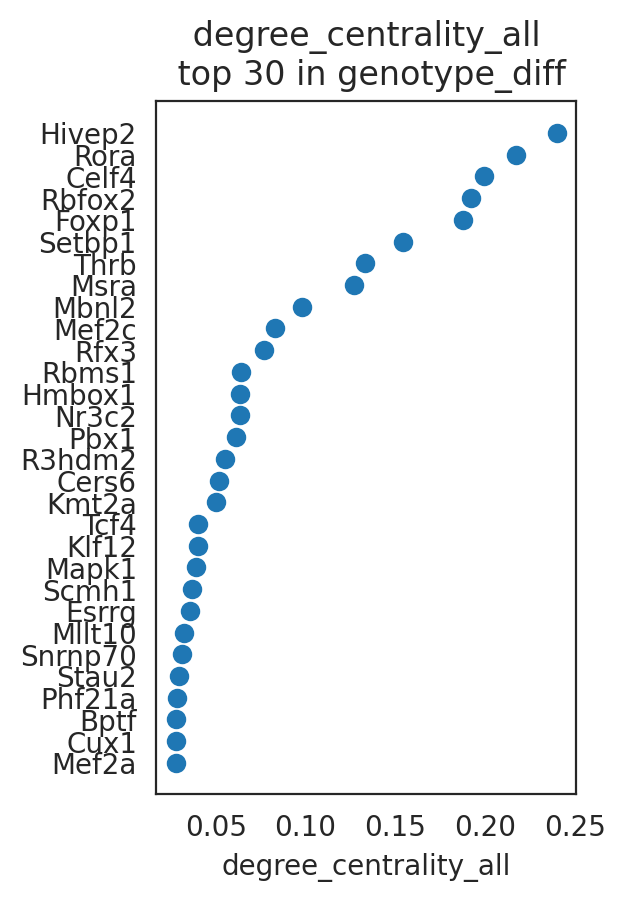

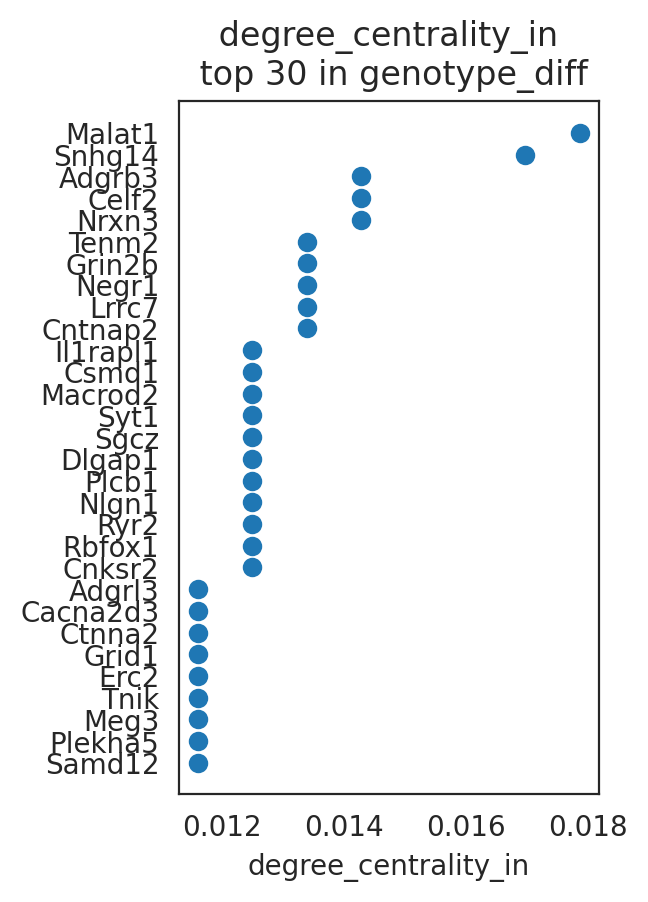

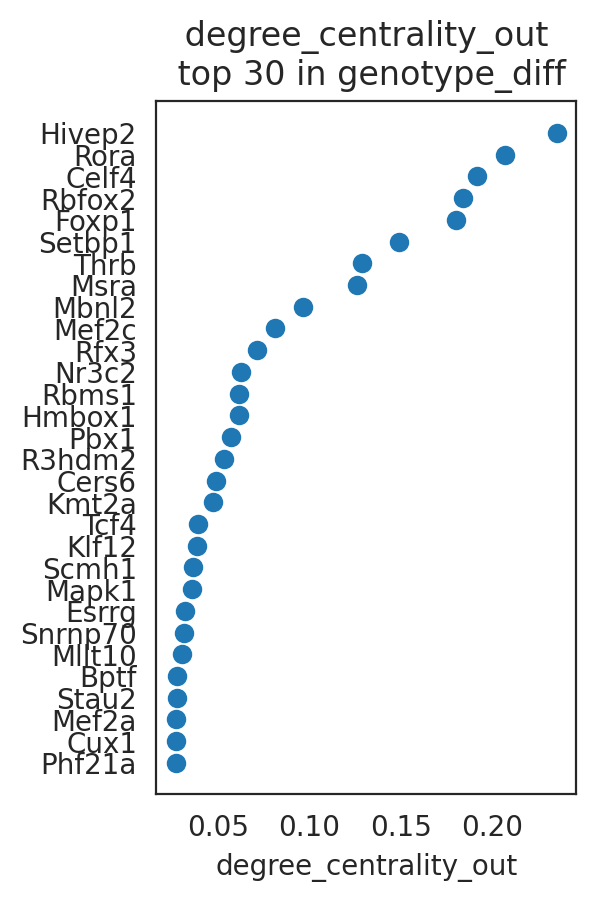

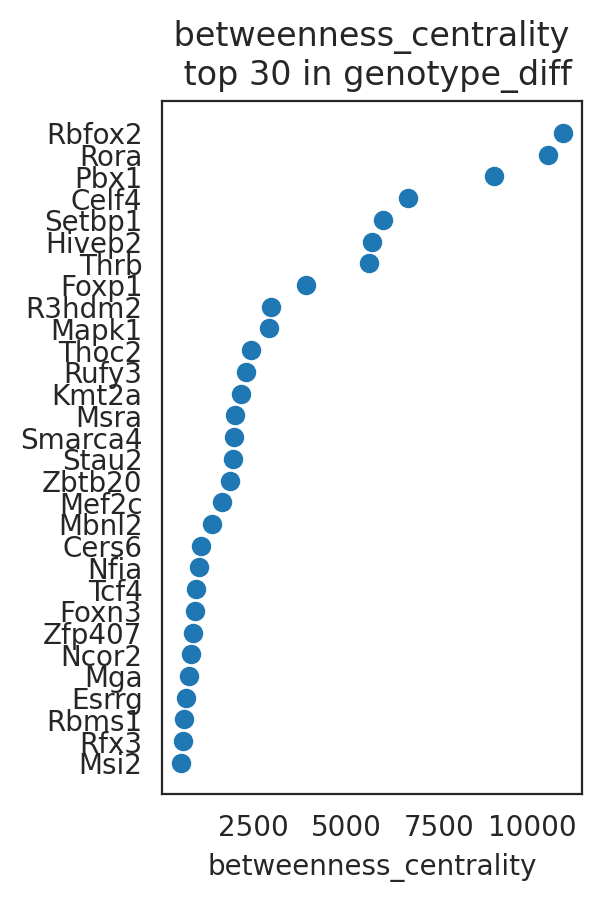

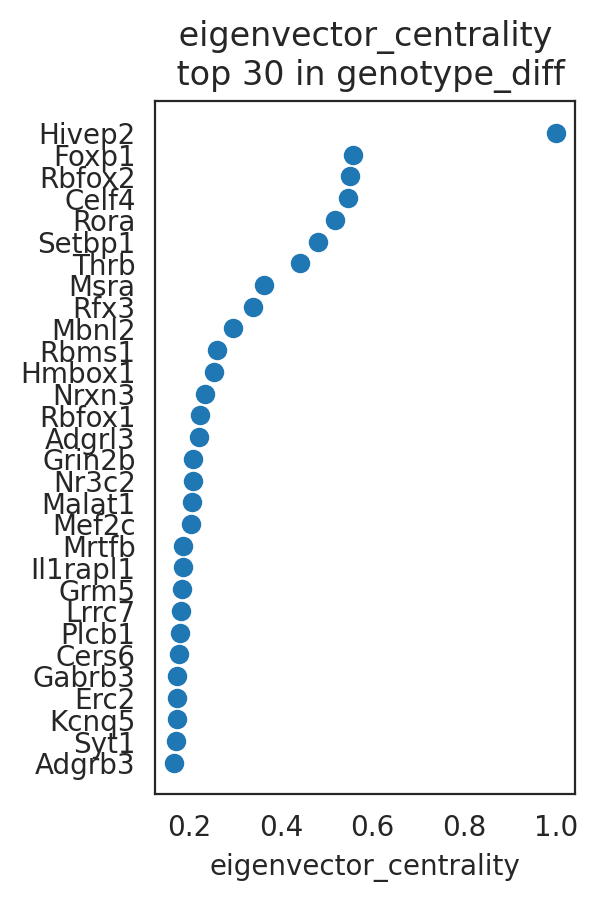

In [307]:
diff_links.plot_scores_as_rank(cluster="genotype_diff", n_gene=30)

In [76]:
b6_adj_list = links_to_adj(links.filtered_links["B6J"])

In [78]:
b6_adj_list.sum(axis=1).sort_values(ascending=False).head(10)

source
Hivep2    300
Celf4     200
Rbfox2    196
Setbp1    180
Thrb      176
Rora      158
Msra      114
Foxp1     102
Pbx1       58
Cers6      51
dtype: int64

In [80]:
b6_adj_list.sum(axis=0).sort_values(ascending=False).head(10)

target
Ptprn2                   11
Map2                     10
Gabrb3                   10
Macrod2                  10
ENSMUSG00000062991.10    10
Mdga2                     9
Grm7                      9
Gria2                     9
Anks1b                    9
Cntnap2                   9
dtype: int64

In [84]:
links.merged_score

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
Rora,165,0.303867,7,0.012891,158,0.290976,1552.0,0.557437,B6J
Tnik,8,0.014733,8,0.014733,0,0.000000,0.0,0.147032,B6J
ENSMUSG00000062991.10,10,0.018416,10,0.018416,0,0.000000,0.0,0.154670,B6J
Lrrc4c,8,0.014733,8,0.014733,0,0.000000,0.0,0.144982,B6J
Msi2,34,0.062615,7,0.012891,27,0.049724,293.0,0.052578,B6J
...,...,...,...,...,...,...,...,...,...
Papola,1,0.001597,1,0.001597,0,0.000000,0.0,0.000019,CASTJ
Tmcc3,1,0.001597,1,0.001597,0,0.000000,0.0,0.000008,CASTJ
Rsf1,1,0.001597,1,0.001597,0,0.000000,0.0,0.002910,CASTJ
Klhdc10,1,0.001597,1,0.001597,0,0.000000,0.0,0.003818,CASTJ
